# Навигация и краткое описание

**Разделы:**
- XGBoost
- LightGBM
- CatBoost

# Подготовка к работе с моделями

In [1]:
import pandas as pd 
from matplotlib import pyplot as plt

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import sys
sys.path.append('..')
from utils import load_processed_data, ModelsRegressionHistory

# Заранее установим несколько констант
RANDOM_STATE = 42

# Загрузка данных
X_train, X_test, y_train, y_test = load_processed_data()
history_models = ModelsRegressionHistory()

# Теория

Бустинг - последовательно обучает модели, где каждая следующая модель исправляет ошибки предыдущих, фокусируясь на плохо предсказанных примерах. Итоговое предсказание формируется путем взвешенного объединения всех моделей.

**более подробную теорию вы можете просмотреть в 2 блокноте*

# Создание моделей

## XGBoost

Считается самой популярной модификацией градиентного бустинга на сегодняшний день. Большая часть соревнований с использованием классического машинного обучения выигрывается с использованием этой модели.

XGBoost - это "золотой стандарт" машинного обучения с табличными данными \[[источник](https://www.geeksforgeeks.org/machine-learning/xgboost-for-regression/)\]. 
Давайте разберём по какой причине XGBoost так хороша:
1) Регуляризация
    В функцию потерь добавлена регуляризация, которая предотвращает переобучение.
    $ Obj(0) = MSE(0) +  Lasso(0)$
    * MSE(0) - функция потерь
    * Lasso(0) - регуляризатор
2) Разбиение
    Построение дерева требует поиска лучшего разбиения по каждому признаку. XGBoost вместо того, чтоб брать весь датасет из 10.000 обьектов (цифра приведена к примеру) возьмёт 100 случайных объектов и выполнит разбиение по ним - это сэкономит огромное количество времени, при минимальной потере качества
3) Разряженные данные
    В датасетах полно пропущенных значений, а также нулей. XGBoost умеет обрабатывать такие данные. Модель автоматически сделает "виток" в дереве для таких данных.
4) Системная оптимизация
    * Модель может разбивать данные параллельно на всех доступных ядрах системы.
    * Часто используемые ланные кэшируются

![XGBoost дерево](../data/images/trees/xgboost.png)

*Мы не будем на данный момент выжимать все соки из каждой последующей модели. И если сейчас получится приемлимый результат, знайте что это не лучший показатель этой модели.*

In [2]:
# хорошим тоном при разработке моделей является вынесение параметров в отдельный словарь, 
# что мы сейчас и сделаем

params = {
    'objective': 'reg:squarederror', 
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE
}

In [3]:
xgbr = XGBRegressor(
    **params
)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

In [4]:
history_models.add_model(xgbr, "tree_model", xgbr.get_params(), "XGBR", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.952,0.02,0.0006,0.0248


А так же мы можем просматреть влияние фичь на предсказания. Какие свойства обьекта большего всего влияют на предсказание.

In [5]:
importance = xgbr.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(
    data={
            'features': list(importance.keys()),
            'score': list(importance.values())
        },
).sort_values(by=['score'], axis=0, ascending=False, ignore_index=True)
importance_df.head()

,features,score
0,duration,110.0
1,days_left,103.0
2,flight_value,89.0
3,class_Economy,49.0
4,stops_encoded,46.0


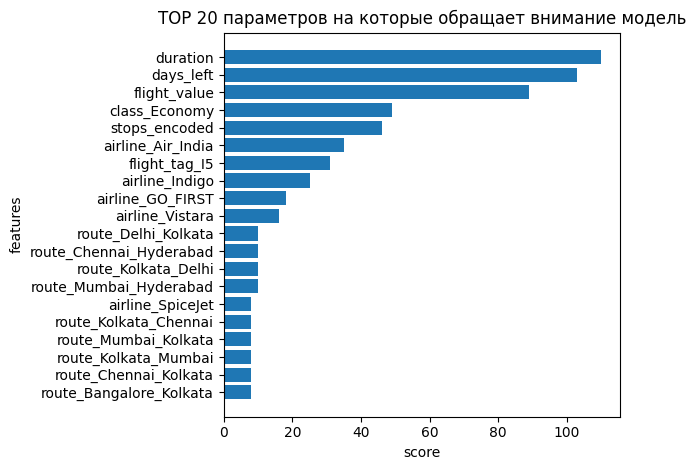

In [6]:
plt.barh(
    importance_df['features'].head(20)[::-1],
    importance_df['score'].head(20)[::-1],
)
plt.title('TOP 20 параметров на которые обращает внимание модель')
plt.ylabel('features')
plt.xlabel('score')
plt.tight_layout()
plt.show()

Теперь в заключении скажем про преимущества и недостатки `XGBoost`

Преимущества:
* высокая скорость обучения и точность прогноза;
* возможность работы с пропусками;
* гибкость в конфигурации.

Недостатки:
* сложно подобрать гиперпараметры(нужен комплексный подход для использования cross-validation);

## LightGBM

Теперь разберём LightGBM(Light Gradient Boosting Machine) - реализация градиентного бустинга от компании "микро мягких"(Microsoft), способная обрабатывать большие наборы данных и при этом обеспечивать точность \[[источник](https://machinelearningmastery.com/exploring-lightgbm-leaf-wise-growth-with-gbdt-and-goss/)\].

Разберём 3 основных момента этой модели.

1) GOSS(Gradient-Based One-Side Sampling)
    Суть этого метода заключается в сортировке и выборе лучших образцов с наибольшим градиентом - это означает, что именно этим данным следует уделить особое внимание, поскольку на них дерево будет ошибкать больше.
2) Leaf-wise Tree Growth
    Метод при котором модель строятся в глубину. Рост продолжается в листовом узле с наибольшим информативным приростом. Такой подход часто превосходит симметричные деревья.

![стратегия](../data/images/trees/leaf_wise_tree_growth_strategy.png)

3) EFB(Exclusive Feature Bundling) 
    Обьединяет разные категориальные фичи в одну фичу, если они крайне редко встречаются вместе.


Схема представленная ниже наглядно описывает логику работы LGBM

![схема LGBM](../data/images/trees/algorithm_lgbm.png)

In [8]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'n_estimators': 100,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE
}

In [10]:
lgbm = LGBMRegressor(
    **params
)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 712
[LightGBM] [Info] Number of data points in the train set: 240018, number of used features: 79
[LightGBM] [Info] Start training from score 9.331057


In [11]:
history_models.add_model(lgbm, "tree_model", lgbm.get_params(), "LGBM", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.9520,0.0200,0.0006,0.0248
1,LGBMRegressor,tree_model,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM,0.1419,0.0400,0.2000,0.9676,0.0157,0.0004,0.0202


In [17]:
importance_df = pd.DataFrame(
    data={
            'features': lgbm.feature_name_,
            'score': lgbm.feature_importances_
        },
).sort_values(by=['score'], axis=0, ascending=False, ignore_index=True)
importance_df.head()

,features,score
0,flight_value,590
1,duration,431
2,days_left,284
3,stops_encoded,110
4,airline_Indigo,87


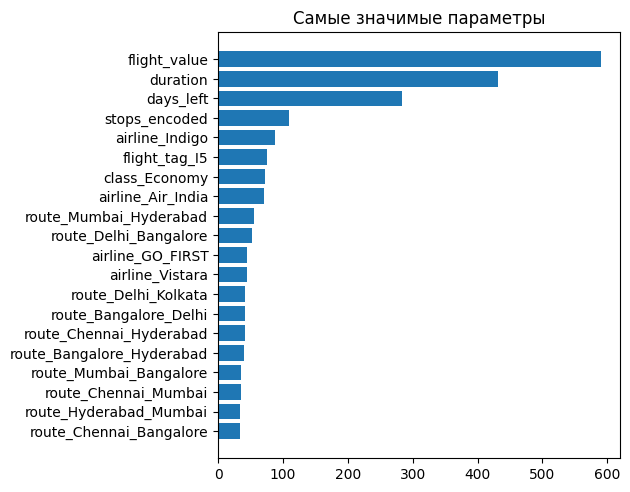

In [20]:
plt.barh(
    importance_df['features'].head(20)[::-1],
    importance_df['score'].head(20)[::-1],
)
plt.tight_layout()
plt.title('Самые значимые параметры')
plt.show()

Сразу же мы можем обратить внимание, что модели отдали 1 место разным параметрам

Теперь в заключении скажем про преимущества и недостатки `LightGBM`

Преимущества:
* высокая точность прогноза;
* возможность работы с категориальными признаками;
* гибкость в конфигурации.

Недостатки:
* возможна нестабильность при работе с небольшими датасетами(виновник этого GROSS);

## CatBoost

CatBoost(Categorical Boosting) - более эффективная реализация градинетного бустинга от компании Яндекс, особенностью которой является возможность работы с категориальными признаками без их дополнительной предобработки. 

При кодировании категориальных признаков к бустингам применяется один из нескольких классических подходов:
* target encoder;
* one-hot encoder;
* feature hashing;
* и другие...

Однако все способы кодирования данных представленые выше могут привести к утечке данных и переобучению. Эту проблему в CatBoost решают с помощью Ordered target encoding, который состоит из w-х этапов:
* Случайная перестановка;
* Статистика "по прошлому";

Наглядный пример такого кодирования представлен на картинке ниже

![ordered target encoding](../data/images/trees/ordered_target_encoding.png)

Структура деревьев в CatBoost заключается в симметричности односторонних деревьев, имеющих одинаковую глубину и ширину, Создатели считают, что такой подход позволяет ускорить обучени и создать деревья, которые менее подвержены переобучению.

![Дерево catboost](../data/images/trees/catboost_tree.png)

In [28]:
params = {
    'objective': 'RMSE',
    'n_estimators': 100,
    'subsample': 0.8,
    'learning_rate': 0.1,
    'random_state': RANDOM_STATE
}

In [29]:
cbr = CatBoostRegressor(
    **params
)
cbr.fit(X_train, y_train)
y_pred = cbr.predict(X_test)

0:	learn: 1.0093942	total: 164ms	remaining: 16.2s
1:	learn: 0.9189388	total: 182ms	remaining: 8.93s
2:	learn: 0.8366229	total: 198ms	remaining: 6.39s
3:	learn: 0.7632566	total: 213ms	remaining: 5.11s
4:	learn: 0.6980347	total: 228ms	remaining: 4.34s
5:	learn: 0.6402593	total: 245ms	remaining: 3.83s
6:	learn: 0.5888799	total: 261ms	remaining: 3.47s
7:	learn: 0.5438547	total: 276ms	remaining: 3.18s
8:	learn: 0.5041281	total: 294ms	remaining: 2.97s
9:	learn: 0.4693948	total: 310ms	remaining: 2.79s
10:	learn: 0.4390431	total: 325ms	remaining: 2.63s
11:	learn: 0.4121911	total: 341ms	remaining: 2.5s
12:	learn: 0.3893593	total: 356ms	remaining: 2.38s
13:	learn: 0.3693902	total: 372ms	remaining: 2.28s
14:	learn: 0.3521529	total: 390ms	remaining: 2.21s
15:	learn: 0.3376733	total: 409ms	remaining: 2.15s
16:	learn: 0.3249906	total: 425ms	remaining: 2.08s
17:	learn: 0.3139213	total: 440ms	remaining: 2s
18:	learn: 0.3047282	total: 456ms	remaining: 1.94s
19:	learn: 0.2969392	total: 471ms	remaining: 

In [30]:
history_models.add_model(cbr, "tree_model", cbr.get_params(), "CatBoost", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.9520,0.0200,0.0006,0.0248
1,LGBMRegressor,tree_model,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM,0.1419,0.0400,0.2000,0.9676,0.0157,0.0004,0.0202
2,CatBoostRegressor,tree_model,"{'learning_rate': 0.1, 'loss_function': 'RMSE'...",CatBoost,0.1676,0.0523,0.2287,0.9577,0.0186,0.0005,0.0232


In [32]:
importance_df = pd.DataFrame(
    data={
            'features': cbr.feature_names_,
            'score': cbr.feature_importances_
        },
).sort_values(by=['score'], axis=0, ascending=False, ignore_index=True)
importance_df.head()

,features,score
0,class_Economy,83.327844
1,days_left,7.597128
2,duration,2.876009
3,flight_tag_I5,1.190039
4,stops_encoded,0.975820


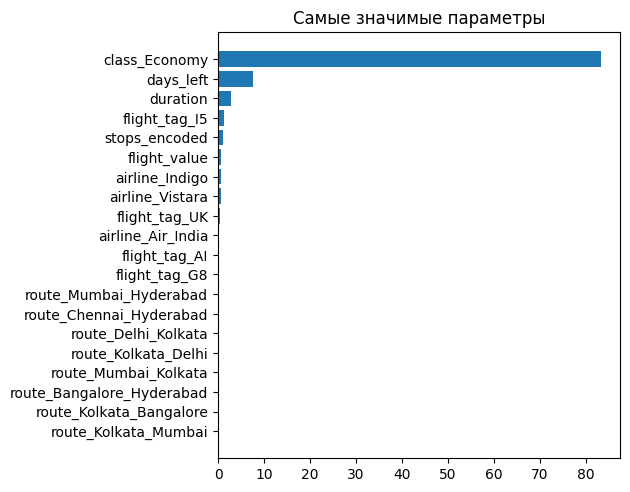

In [33]:
plt.barh(
    importance_df['features'].head(20)[::-1],
    importance_df['score'].head(20)[::-1],
)
plt.tight_layout()
plt.title('Самые значимые параметры')
plt.show()

Мы обучали catboost на заготовленныех данных, теперь давайте попробуем обучить его используя датасет без предобработки

In [41]:
import os 
from sklearn.model_selection import train_test_split

# загрузка сырого датасета
data_path = os.path.join('..', 'data', 'raw', 'Clean_Dataset.csv')
df = pd.read_csv(data_path)
df = df.drop(df.columns[0], axis=1)
y = df['price']
X = df.drop('price', axis=1)
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(
    X, y,
    test_size=0.2, 
    random_state=42
)

In [48]:
cat_features = list(X_raw_train.select_dtypes('object').columns)

cbr_raw = CatBoostRegressor(
    **params,
    cat_features=cat_features
)
cbr_raw.fit(X_raw_train, y_raw_train)
y_raw_pred = cbr_raw.predict(X_raw_test)

0:	learn: 20602.9019475	total: 54.3ms	remaining: 5.37s
1:	learn: 18713.5465155	total: 110ms	remaining: 5.38s
2:	learn: 17023.5677034	total: 164ms	remaining: 5.31s
3:	learn: 15522.2796136	total: 234ms	remaining: 5.61s
4:	learn: 14181.3192284	total: 295ms	remaining: 5.6s
5:	learn: 12997.2337504	total: 347ms	remaining: 5.44s
6:	learn: 11958.6537835	total: 403ms	remaining: 5.35s
7:	learn: 11033.4424188	total: 458ms	remaining: 5.27s
8:	learn: 10214.1248674	total: 518ms	remaining: 5.24s
9:	learn: 9500.0219337	total: 583ms	remaining: 5.25s
10:	learn: 8873.3282520	total: 639ms	remaining: 5.17s
11:	learn: 8338.4950837	total: 700ms	remaining: 5.13s
12:	learn: 7872.5832528	total: 756ms	remaining: 5.06s
13:	learn: 7465.6215545	total: 812ms	remaining: 4.99s
14:	learn: 7116.8337767	total: 872ms	remaining: 4.94s
15:	learn: 6811.9050505	total: 932ms	remaining: 4.89s
16:	learn: 6556.0681841	total: 992ms	remaining: 4.84s
17:	learn: 6343.7402255	total: 1.05s	remaining: 4.78s
18:	learn: 6156.0412169	total

In [49]:
history_models.add_model(cbr_raw, "tree_model", cbr_raw.get_params(), "CatBoost с сырыми данными", y_true=y_test, y_pred=y_pred)
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.9520,0.0200,0.0006,0.0248
1,LGBMRegressor,tree_model,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM,0.1419,0.0400,0.2000,0.9676,0.0157,0.0004,0.0202
2,CatBoostRegressor,tree_model,"{'learning_rate': 0.1, 'loss_function': 'RMSE'...",CatBoost,0.1676,0.0523,0.2287,0.9577,0.0186,0.0005,0.0232
3,CatBoostRegressor,tree_model,"{'learning_rate': 0.1, 'loss_function': 'RMSE'...",CatBoost с сырыми данными,0.1676,0.0523,0.2287,0.9577,0.0186,0.0005,0.0232


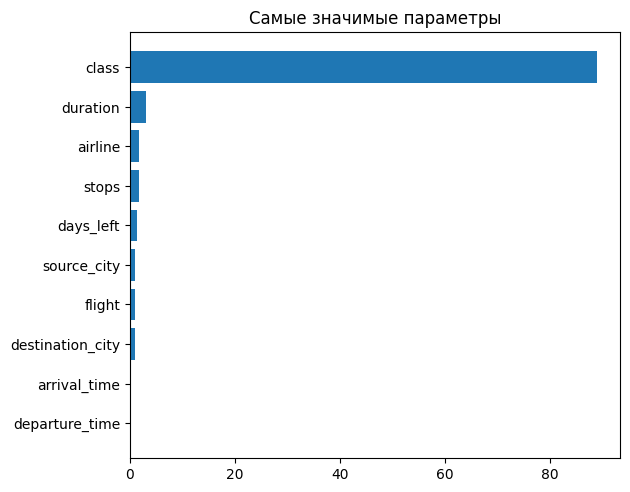

In [50]:
importance_df = pd.DataFrame(
    data={
            'features': cbr_raw.feature_names_,
            'score': cbr_raw.feature_importances_
        },
).sort_values(by=['score'], axis=0, ascending=False, ignore_index=True)
importance_df.head()

plt.barh(
    importance_df['features'].head(20)[::-1],
    importance_df['score'].head(20)[::-1],
)
plt.tight_layout()
plt.title('Самые значимые параметры')
plt.show()

CatBoost с разными данными(сырыми и обработанными) предсказывает с одинаковой точностью.

Теперь в заключении скажем про преимущества и недостатки `CatBoost`

Преимущества:
* высокая точность прогноза без дополнительных подборов гиперпараметров;
* возможность работы с категориальными признаками;

Недостатки:
* потребляет много RAM;

# Итог

In [51]:
history_models.to_dataframe()

,Модели,Класс модели,Параметры модели,Заметки,MAE,MSE,RMSE,R^2,MAPE,MSLE,RMSLE
0,XGBRegressor,tree_model,"{'objective': 'reg:squarederror', 'base_score'...",XGBR,0.1793,0.0593,0.2436,0.9520,0.0200,0.0006,0.0248
1,LGBMRegressor,tree_model,"{'boosting_type': 'gbdt', 'class_weight': None...",LGBM,0.1419,0.0400,0.2000,0.9676,0.0157,0.0004,0.0202
2,CatBoostRegressor,tree_model,"{'learning_rate': 0.1, 'loss_function': 'RMSE'...",CatBoost,0.1676,0.0523,0.2287,0.9577,0.0186,0.0005,0.0232
3,CatBoostRegressor,tree_model,"{'learning_rate': 0.1, 'loss_function': 'RMSE'...",CatBoost с сырыми данными,0.1676,0.0523,0.2287,0.9577,0.0186,0.0005,0.0232


Проанализировав полученные метрики можно одназночно сказать, что LGBM лидирует по сравнению с другими моделями.

После такого краткого обзора мы можем резюмировать когда какую модель стоит выбрать:
* CatBoost - когда нужно максимально быстро сделать готовую модель;
* LightGBM - когда скорость обучения модели критически важна;
* XGBoost - когда нужна максимальная точность на данных среднего размера.